In [1]:
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from Bio import Phylo
import re
from matplotlib.colors import ListedColormap
import phylovelo as pv

plt.rcParams['font.size'] = 12

In [2]:
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'
ldata = scv.read(data_path + 'embryo6/embryo6out-2.loom', cache=False)
ldata.var_names_make_unique
metadata = pd.read_csv(data_path + 'embryo6/scRNA_metadata.csv', index_col=0)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
ldata.obs_names = [i[13:-1] for i in ldata.obs_names]

In [4]:
sel_cells = metadata.index[np.isin(metadata.cluster, [1,11,24,33,39])]
sel_cells = sel_cells[np.isin(sel_cells, ldata.obs_names)]
ldata = ldata[sel_cells]
metadata = metadata.loc[sel_cells]

In [5]:
em = 6
alleletab = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0) 
mutnum = []
for bc in sel_cells:
    try:
        sel_alleles = alleletab.loc[f'{bc}-1']
        if len(sel_alleles.shape) == 2:
            sel_alleles = '_'.join(sel_alleles['allele1']).split('_')
        else:
            sel_alleles = sel_alleles['allele1'].split('_')

        mutnum.append(len(sel_alleles)-sel_alleles.count('None'))
    except:
        mutnum.append(np.nan)
mutnum = np.array(mutnum)

In [7]:
ldata = ldata[~np.isnan(mutnum)]
metadata = metadata[~np.isnan(mutnum)]
mutnum = mutnum[~np.isnan(mutnum)]

In [8]:
sd = pv.scData(count = pd.DataFrame(ldata.X.A, index=ldata.obs_names, columns=ldata.var_names).astype(int))

In [9]:
scv.pp.filter_and_normalize(ldata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(ldata, n_pcs=30, n_neighbors=30)  #calculate the first and second order moments

scv.tl.recover_dynamics(ldata)
scv.tl.velocity(ldata, mode="dynamical")
scv.tl.velocity_graph(ldata)

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Filtered out 28536 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/160 cores)


  0%|          | 0/322 [00:00<?, ?gene/s]

    finished (0:00:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/160 cores)


  0%|          | 0/2490 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [10]:
ldata.obs['cell_type'] = metadata.cluster

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


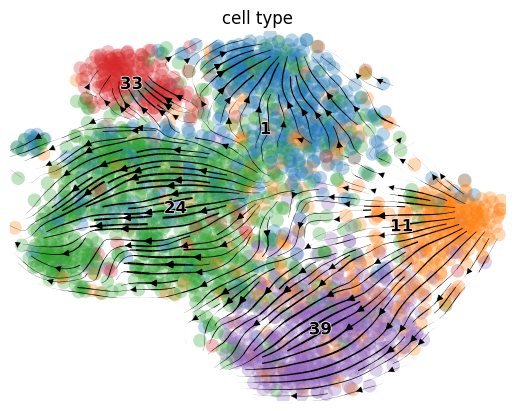

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


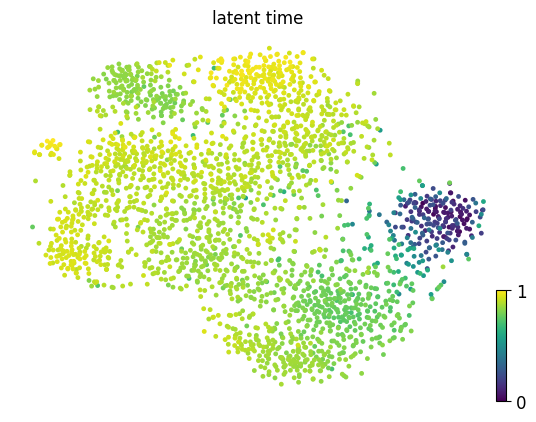

In [11]:
scv.tl.tsne(ldata)
# scv.tl.louvain(ldata1)
"""
Project the velocities
"""
#scv.pl.velocity_embedding_stream(ldata1, basis='umap')
scv.pl.velocity_embedding_stream(ldata, basis='X_tsne',color="cell_type")#,ax=ax[0,0], show=False
scv.tl.latent_time(ldata)
scv.pl.scatter(ldata, color='latent_time', cmap='viridis')

In [12]:
sd.Xdr = pd.DataFrame(data=ldata.obsm['X_tsne'], index=ldata.obs_names)
sd.cell_states = ldata.obs['cell_type'].astype(int)

In [13]:
sd.drop_duplicate_genes()
sd.normalize_filter()

In [14]:
pv.velocity_inference(sd, mutnum, cutoff=0.97, target='x_normed')

  0%|          | 0/11865 [00:00<?, ?it/s]

In [15]:
len(sd.megs)

325

In [16]:
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/2490 [00:00<?, ?it/s]

In [17]:
cmap = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
color_map = dict(zip([1, 11, 24, 33, 39], [0, 1, 2, 3, 4]))
state_map = dict(zip([1, 11, 24, 33, 39], ['neural ectoderm anterior', 'neural ectoderm posterior', 'fore/midbrain', 'neural crest', 'future spinal cord']))

AttributeError: module 'phylovelo' has no attribute 'label_name'

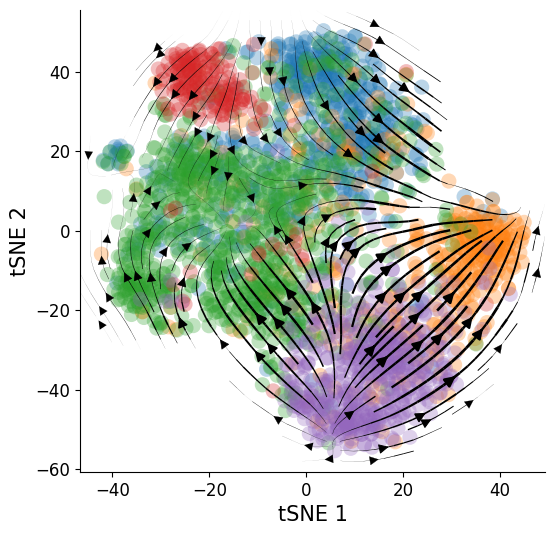

In [28]:
fig, ax = plt.subplots()
for i in [1, 11, 24, 33, 39]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, radius=5, lw_coef=4000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
pv.ana_utils.label_name()
# plt.savefig('./figures/fig4/stream.pdf', dpi='figure', format='pdf')

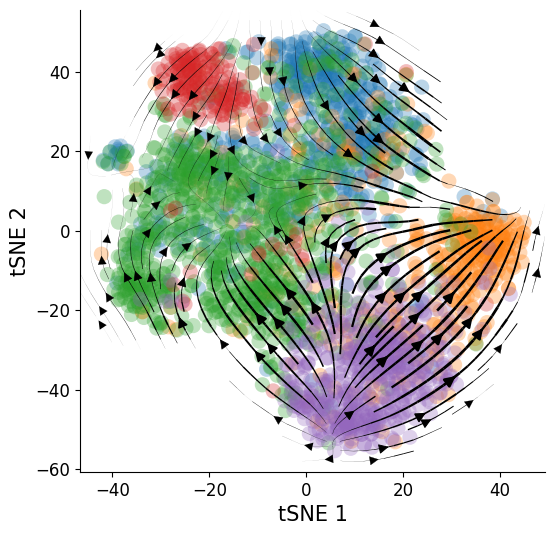

In [25]:
fig, ax = plt.subplots()
for i in [1, 11, 24, 33, 39]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.5, radius=5, lw_coef=4000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
# ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/fig4/stream.pdf', dpi='figure', format='pdf')

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [46]:
sd = pv.pseudo_time.calc_phylo_pseudotime(sd, n_neighbors=50, r_sample=0.4)

  0%|          | 0/966 [00:00<?, ?it/s]

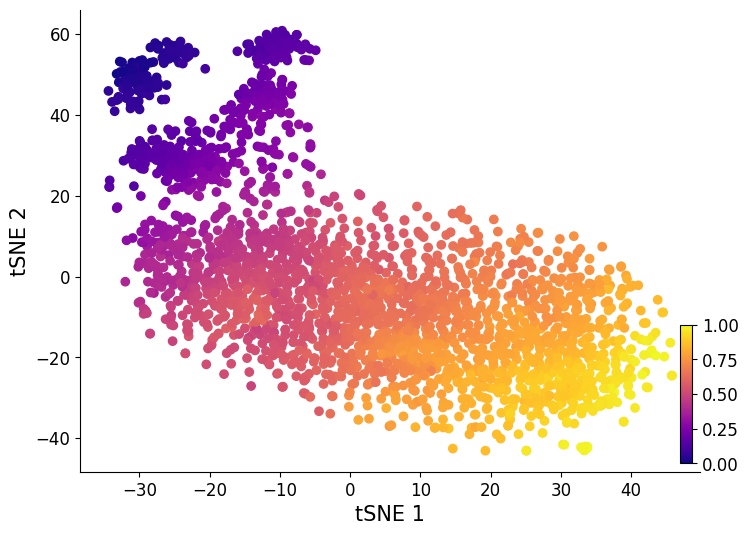

In [47]:

fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(sd.Xdr.iloc[:,0],sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime,cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="2%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/fig4/phylo_pseudotime.pdf', dpi='figure', format='pdf')

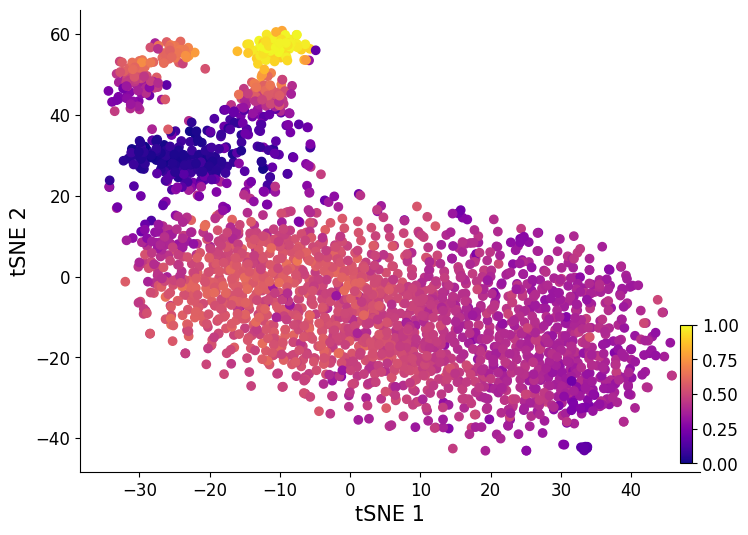

In [23]:
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(sd.Xdr.iloc[:,0],sd.Xdr.iloc[:,1], c=ldata1.obs.latent_time[sd.Xdr.index],cmap='plasma')
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
cbaxes = inset_axes(ax, width="2%", height="30%", loc='lower right') 
plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/scVelo_latenttime.pdf', dpi='figure', format='pdf')

Text(0, 0.5, 'Fraction')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


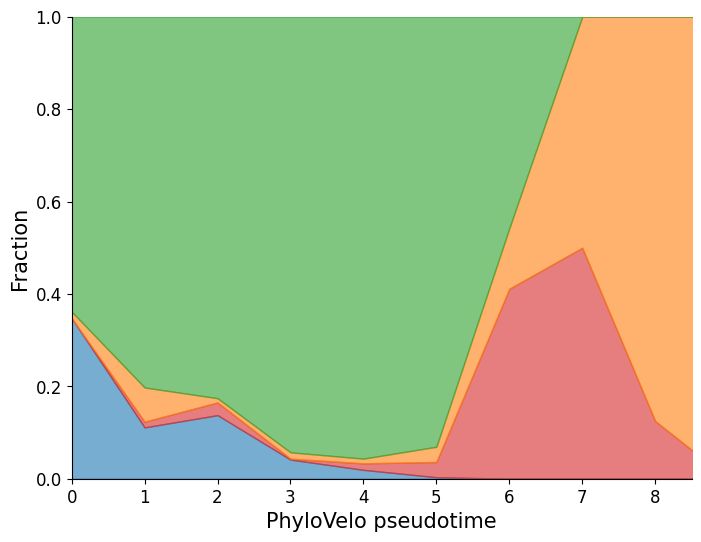

In [48]:
phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = ldata1.obs.latent_time[sd.Xdr.index].to_numpy()[np.where(np.array(sd.cell_states)==i)]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(sd.cell_states):
    hist_data.append(phytime_bar[state_map[i]])
    hist_labels.append(state_map[i])
    hist_colors.append(cmap[color_map[i]])
    
hd = ax.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))
pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PhyloVelo pseudotime', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
# plt.savefig('./figures/embryo3_blood/latent_time_muller.pdf', dpi='figure', format='pdf')

Text(0, 0.5, 'Fraction')

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


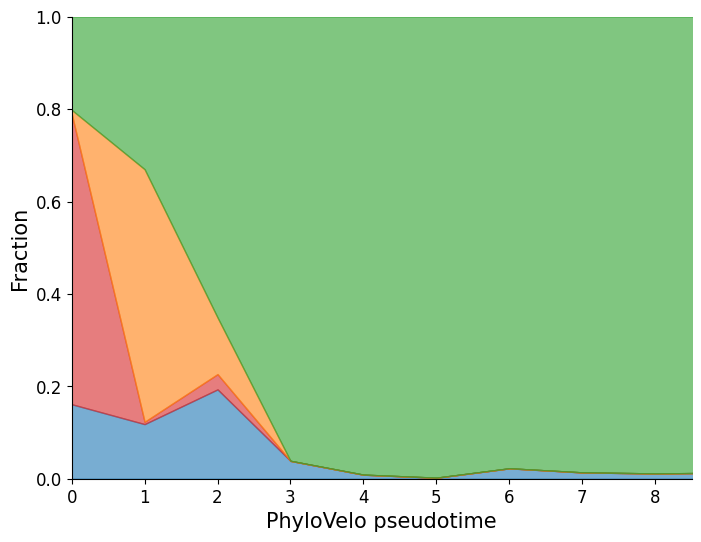

In [ ]:
phytime_bar = dict()
for i in state_map:
    phytime_bar[state_map[i]] = sd.phylo_pseudotime[np.where(np.array(sd.cell_states)==i)]
hist_data = []
hist_labels = []
hist_colors = []
for i in set(sd.cell_states):
    hist_data.append(phytime_bar[state_map[i]])
    hist_labels.append(state_map[i])
    hist_colors.append(cmap[color_map[i]])
hd = ax.hist(hist_data, label=hist_labels, color=hist_colors,alpha=0.7)
fig, ax = plt.subplots(figsize=(8,6))
pv.ana_utils.mullerplot(hd[0],hist_labels, hist_colors, absolute=0,alpha=0.6, ax=ax)
ax.set_xlim(0, 8.5)
ax.set_ylim(0, 1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('PhyloVelo pseudotime', font='Arial', fontsize=15)
ax.set_ylabel('Fraction', fontsize=15)
# plt.savefig('./figures/embryo3_blood/phylo_pseudotime_muller.pdf', dpi='figure', format='pdf')

In [65]:
from sklearn.preprocessing import scale
import seaborn as sns
from scipy.stats import spearmanr

genes1 = sd.x_normed.columns[sd.velocity>0]
genes2 = sd.x_normed.columns[sd.velocity<0]

genetraj1 = []
for i in genes1:
    genetraj1.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj1 = np.array(genetraj1)
# genetraj1 = np.log(1+genetraj1)
# genetraj1 = (genetraj1.T / np.max(genetraj1, axis=1)).T

genetraj2 = []
for i in genes2:
    genetraj2.append(scale(list(sd.x_normed[i][np.argsort(sd.phylo_pseudotime)])))
genetraj2 = np.array(genetraj2)
# genetraj2 = np.log(1+genetraj2)

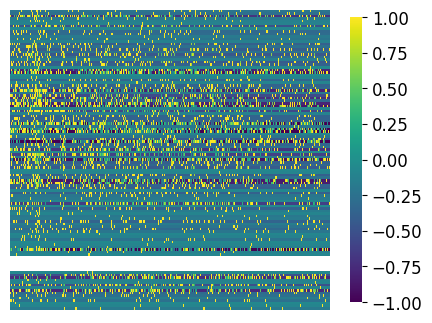

In [75]:
fig = plt.figure(figsize=(4, 3))
h1 = len(genes1)/(len(genes1)+len(genes2))
h2 = len(genes2)/(len(genes1)+len(genes2))
ax1 = plt.axes([0.05, 0, 0.8, 0.95*h1])
ax2 = plt.axes([0.05, 0.95*h1+0.05, 0.8, 0.95*h2])
ax3 = plt.axes([0.9,0.025,0.03,0.95])

ax1 = sns.heatmap(genetraj1, cmap='viridis', ax=ax1, cbar_ax=ax3,vmax=1, vmin=-1, xticklabels=False, yticklabels='')
ax2 = sns.heatmap(genetraj2, cmap='viridis', ax=ax2, cbar=False,vmax=1, vmin=-1, xticklabels=False, yticklabels='')

# plt.savefig('./figures/EMT/heatmap_full_phylopseudotime.pdf', dpi='figure', format='pdf')

In [18]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
# v_megs.to_csv('./megs/em3_erythoid.csv')

In [79]:
import pickle
with open('/data3/wangkun/result_sd/erythroid.pkl', 'wb') as f:
    pickle.dump(sd, f)